In [1]:
# Importing dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
# Importing dependencies
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Importing Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# Creating engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Reflecting an existing database into a new model
Base = automap_base()
# Reflecting the tables
Base.prepare(autoload_with=engine)

In [6]:
# Viewing all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Saving references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [8]:
# Creating session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Finding the most recent date in the data set.

In [10]:
## Using the inspect method to inspect the data
inspector = inspect(engine)

In [11]:
## Getting the column names and types from measurement table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
## Getting the column names and types from station table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [46]:
## Generating a query object which orders the rows in descending order and grabs the first row value, a.k.a the most recent date
most_recent = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
most_recent

'2017-08-23'

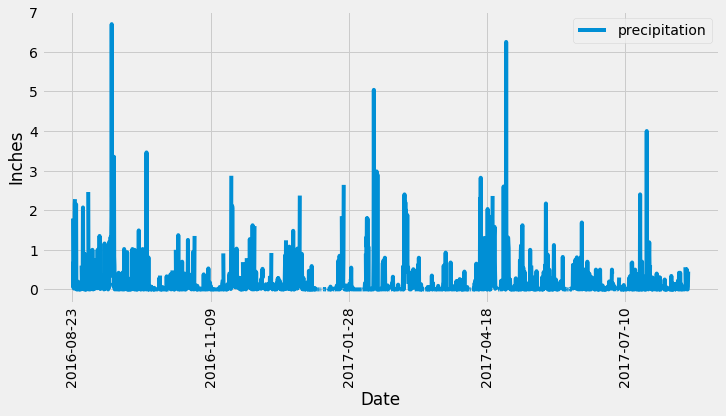

In [86]:
# Designing a query to retrieve the last 12 months of precipitation data and plot the results. 
## Starting from the most recent data point in the database. 

## Calculating the date one year from the last date in data set using the datetime library
query_date = dt.date(2017, 8, 23) - dt.timedelta(days = 365)
query_date

## Performing a query to retrieve the data and precipitation scores by using filter to only retrieve data for dates greater than or equal to the query date
precip_scores = session.query(measurement.prcp, measurement.date).\
    filter(measurement.date >= query_date).all()
precip_scores

## Saving the query results as a Pandas DataFrame and setting the index to the date column
data = pd.DataFrame(precip_scores, columns = ["precipitation", "date"])
data.set_index("date")

## Sorting the dataframe by date
data.sort_values(by = ["date"], inplace=True)

## Using Pandas Plotting with Matplotlib to plot the data
data.plot(x = "date", y = "precipitation", figsize = (10, 6), rot = 90)
plt.tight_layout()
plt.xlabel("Date")
plt.ylabel("Inches")
plt.show()


In [15]:
# Using Pandas to calcualte the summary statistics for the precipitation data
data.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [16]:
# Designing a query to calculate the total number stations in the dataset using the distinct and count functions
total = session.query(measurement.station).distinct().count()
total

9

In [22]:
# Designing a query to find the most active stations (i.e. what stations have the most rows?)
## Listing the stations and the counts in descending order.
most_active_list = session.query(measurement.station, func.count(measurement.id)).\
group_by(measurement.station).\
order_by(func.count(measurement.id).desc()).all()
most_active_list

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [23]:
most_active_station = most_active_list[0][0]
most_active_station

'USC00519281'

In [24]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_temps = session.query(measurement.station, func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
filter(measurement.station == most_active_station).all()
most_active_temps

for value in most_active_temps:
    print(f"Station: {value[0]},\nMinimum temperature: {value[1]},\nMaximum temperature: {value[2]},\nAverage temperature: {value[3]}")

Station: USC00519281,
Minimum temperature: 54.0,
Maximum temperature: 85.0,
Average temperature: 71.66378066378067


Text(0.5, 0, 'Temperature')

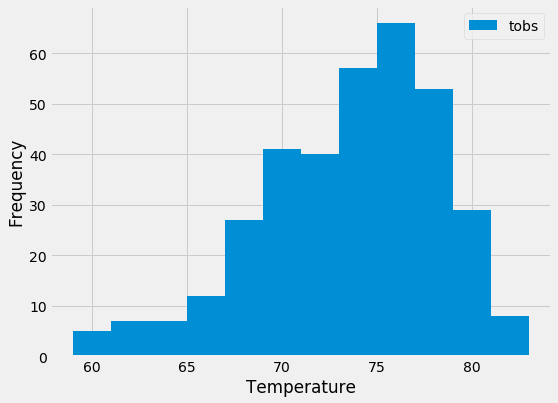

In [26]:
# Using the most active station id to query the last 12 months of temperature observation data
most_active_temps_last_12 = session.query(measurement.tobs, measurement.date).\
filter(measurement.date >= dt.date(2016, 8, 23)).\
filter(measurement.station == 'USC00519281').all()

# Plotting the results as a histogram
temp_data = pd.DataFrame(most_active_temps_last_12, columns = ["tobs", "date"])
temp_data.plot(kind = 'hist', figsize = (8, 6), bins = 12)
plt.xlabel("Temperature")

# Close session

In [27]:
# Close Session
session.close()